# Data exploratory analysis 

### Load modules

In [1]:
# General
import os
import math
import re
from glob import glob
import pickle
from tqdm.notebook import tqdm

# Data handling
import numpy as np
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Image handling
import cv2
import rasterio
from skimage.draw import polygon2mask
from skimage import color

from utilities import get_mask

In [2]:
# import resource

# def memory_limit():
#     soft, hard = resource.getrlimit(resource.RLIMIT_AS)
#     resource.setrlimit(resource.RLIMIT_AS, (get_memory() * 1024 / 2, hard))

# def get_memory():
#     with open('/proc/meminfo', 'r') as mem:
#         free_memory = 0
#         for i in mem:
#             sline = i.split()
#             if str(sline[0]) in ('MemFree:', 'Buffers:', 'Cached:'):
#                 free_memory += int(sline[1])
#     return free_memory

# memory_limit()

## Load Data

### Load patient data

In [3]:
train_segmentation = pd.read_csv('data/train.csv')
train_segmentation.head(5)

,id,encoding
0,2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
1,8242609fa,96909968 56 96941265 60 96972563 64 97003861 6...
2,aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
3,cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
4,b9a3865fc,61271840 4 61303134 13 61334428 22 61365722 30...


This csv file links the id of each sample to the ground truth segmentation in a run-length encoding

In [4]:
train_patient_data = pd.read_csv('data/HuBMAP-20-dataset_information.csv')
train_patient_data.head(5)

,image_file,width_pixels,height_pixels,anatomical_structures_segmention_file,glomerulus_segmentation_file,patient_number,race,ethnicity,sex,age,weight_kilograms,height_centimeters,bmi_kg/m^2,laterality,percent_cortex,percent_medulla
0,aa05346ff.tiff,47340,30720,aa05346ff-anatomical-structure.json,aa05346ff.json,67347,White,Not Hispanic or Latino,Female,58,59.0,160.0,23.0,Right,80,20
1,afa5e8098.tiff,43780,36800,afa5e8098-anatomical-structure.json,afa5e8098.json,67347,White,Not Hispanic or Latino,Female,58,59.0,160.0,23.0,Right,55,45
2,54f2eec69.tiff,22240,30440,54f2eec69-anatomical-structure.json,54f2eec69.json,67548,Black or African American,Not Hispanic or Latino,Male,58,79.9,190.5,22.0,Right,75,25
3,d488c759a.tiff,29020,46660,d488c759a-anatomical-structure.json,d488c759a.json,68138,White,Not Hispanic or Latino,Female,66,81.5,158.8,32.2,Left,100,0
4,1e2425f28.tiff,32220,26780,1e2425f28-anatomical-structure.json,1e2425f28.json,63921,White,Not Hispanic or Latino,Male,48,131.5,193.0,35.3,Right,65,35


This dataframe holds infomration about the size of the image as well as data from the patient like heigth, weight, sex, etc. There is some redundant information like the name of the files, that can be derived from the sample id. I will merge this dataframe and train_segmentation. 

In [5]:
# Add a column for the sample id in train_patient_data
train_patient_data['sample_id'] = train_patient_data.image_file.apply(lambda x: x.split('.')[0])

In [6]:
# Merge train_segmentation and train_patient_data using the sample id columns
train = pd.merge(train_segmentation, train_patient_data, left_on='id', right_on='sample_id')

# Remove non desired columns
train = train.drop(['id', 'image_file', 'anatomical_structures_segmention_file',
            'glomerulus_segmentation_file', 'patient_number', 'encoding'], axis=1)

# format column names
train.columns = ['width_pixels', 'height_pixels', 'race', 'ethnicity', 'sex',
       'age', 'weight', 'height', 'bmi', 'laterality', 'percent_cortex',
                 'percent_medulla', 'sample_id']

## Patient data

### Image size

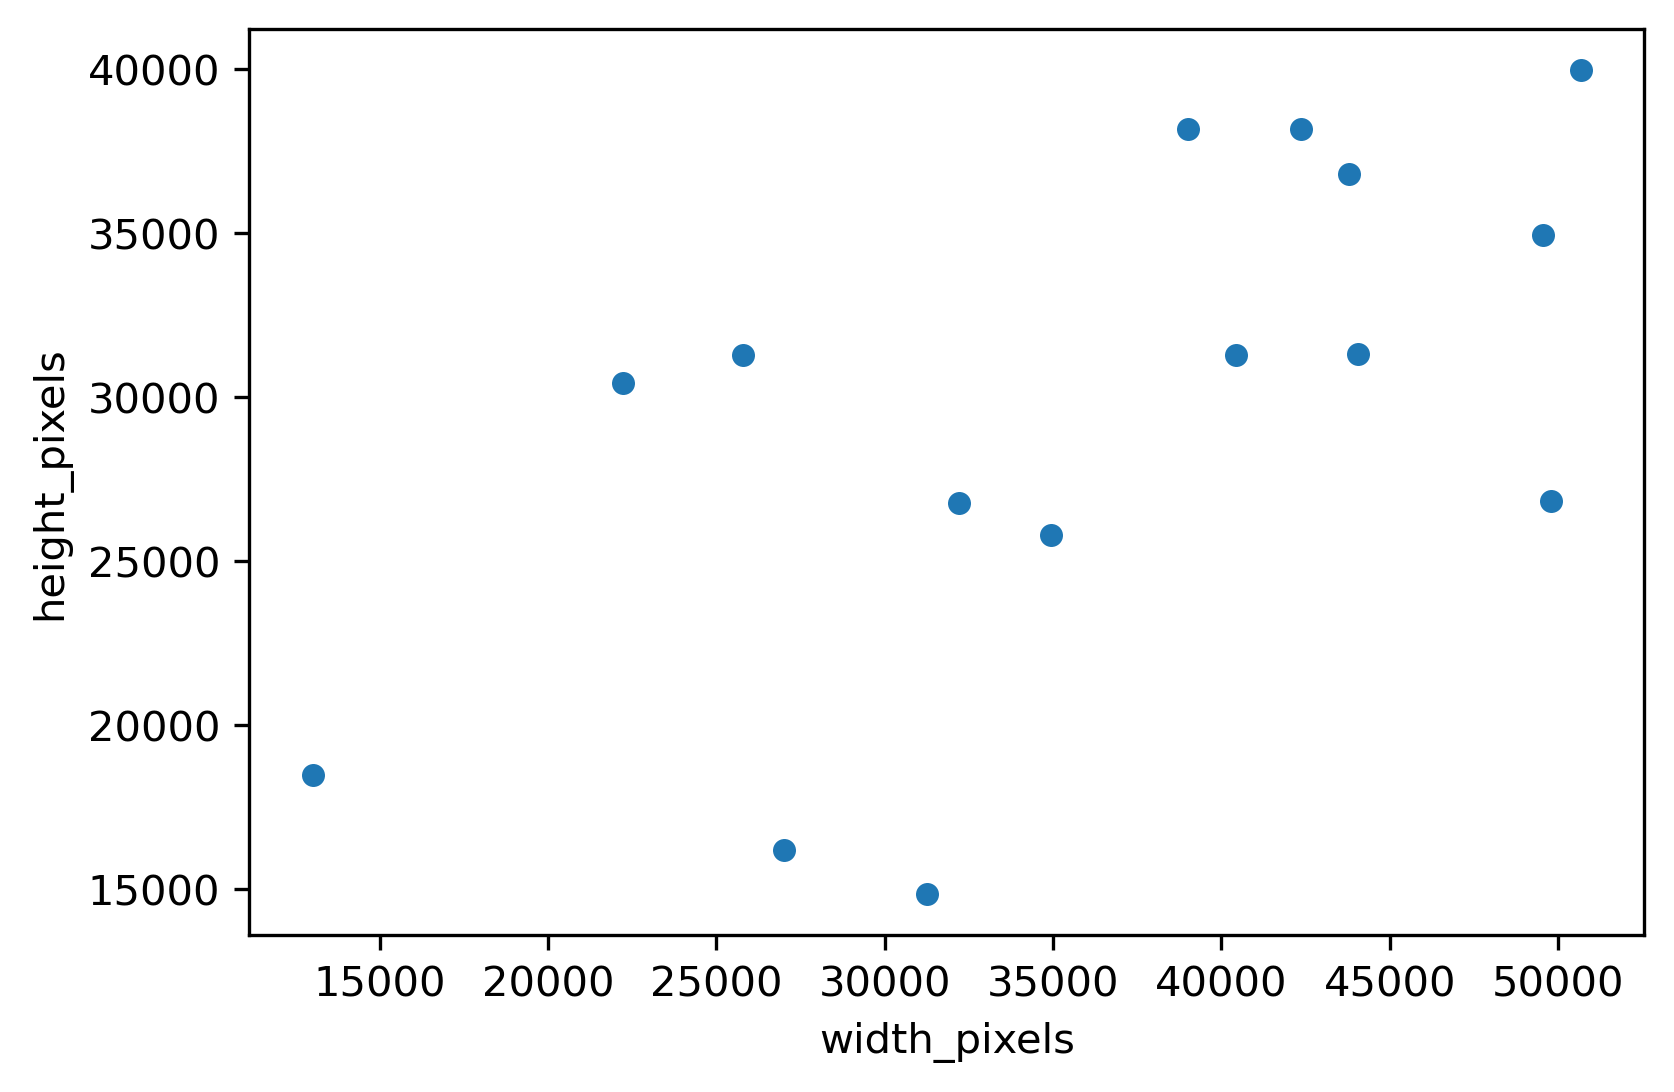

In [7]:
plt.figure(dpi=300)
sns.scatterplot(data=train, x='width_pixels', y='height_pixels')
plt.show()

### race

In [8]:
def plot_categorical_feature(feature):
    race_count = train[feature].value_counts().reset_index()
    race_count.columns = [feature, 'count']
    
    sns.catplot(data=race_count, x=feature, y='count', kind='bar')
    plt.show()

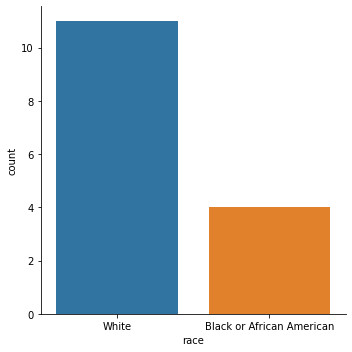

In [9]:
plot_categorical_feature('race')

### ethnicity

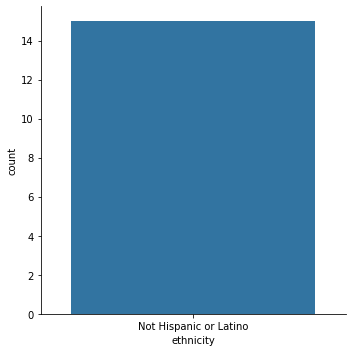

In [10]:
plot_categorical_feature('ethnicity')

This feature only has one value so it is not adding any value to our model

In [11]:
train = train.drop('ethnicity', axis=1)

### sex

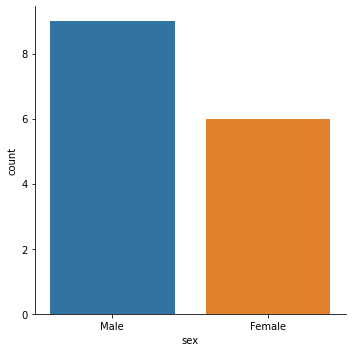

In [12]:
plot_categorical_feature('sex')

### age

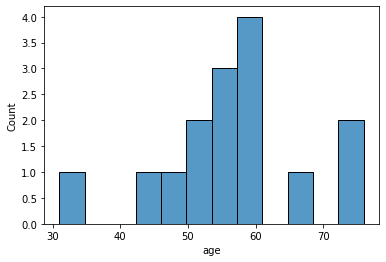

In [13]:
sns.histplot(train.age)
plt.show()

### weight

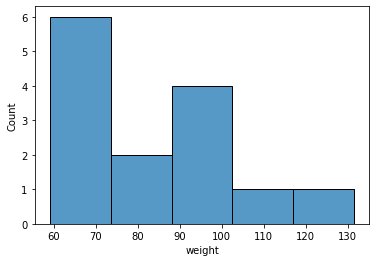

In [14]:
sns.histplot(train.weight)
plt.show()

### height

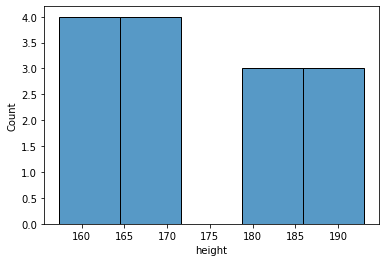

In [15]:
sns.histplot(train.height)
plt.show()

### bmi

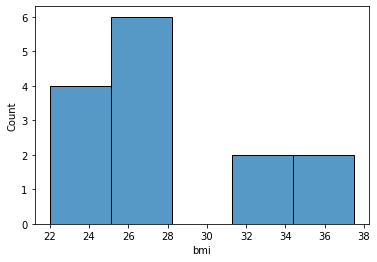

In [16]:
sns.histplot(train.bmi)
plt.show()

### laterality

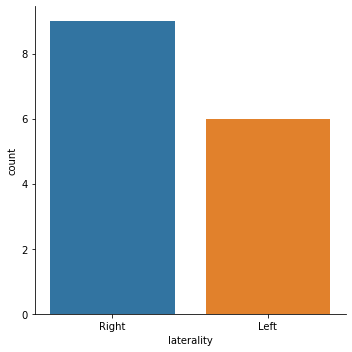

In [17]:
plot_categorical_feature('laterality')

### percent_cortex

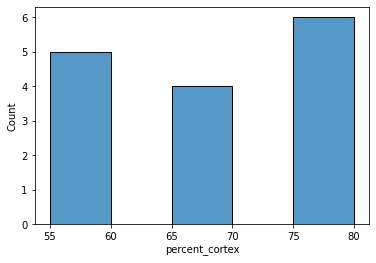

In [18]:
sns.histplot(train.percent_cortex)
plt.show()

### percent_medulla

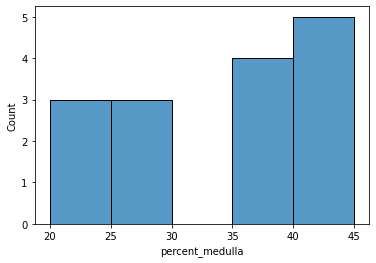

In [19]:
sns.histplot(train.percent_medulla)
plt.show()

## Images

In [20]:
def load_image(sample_id, out_res=(500,500), bw=False):
    
    """Takes a sample id and return the image as a numpy array of shape out_res"""
    
    # Get the path of the image of the smaple
    path = glob(f"data/train/{sample_id}.tiff")[0]
    
    # Load the image
    with rasterio.open(path) as src:        
        sample_image = src.read(out_shape=out_res,
                                resampling=rasterio.enums.Resampling.cubic)
        # Move first chanel axis from the first to the last position and normalize it
        sample_image = np.moveaxis(sample_image, 0, -1)/255
        
        if bw and sample_image.shape[-1] == 3:
            sample_image = color.rgb2gray(sample_image)
        
    return sample_image

In [21]:
# Loading images into a dictionary. To speed up the process the cell saves a 
# pickle file the first time it is executed
# ! rm im_dict.pickle
if os.path.exists('im_dict.pickle'):
    im_dict = pickle.load(open('im_dict.pickle', 'rb'))
else:
    im_dict = {}

    for sample_id in tqdm(train.sample_id):

        if sample_id in im_dict.keys():
            continue

        try:
            image = load_image(sample_id, bw=True)
        except:
            print(f'Failed to load image {sample_id}')
            continue


        im_dict[sample_id] = image
    pickle.dump(im_dict, open('im_dict.pickle', 'wb'))

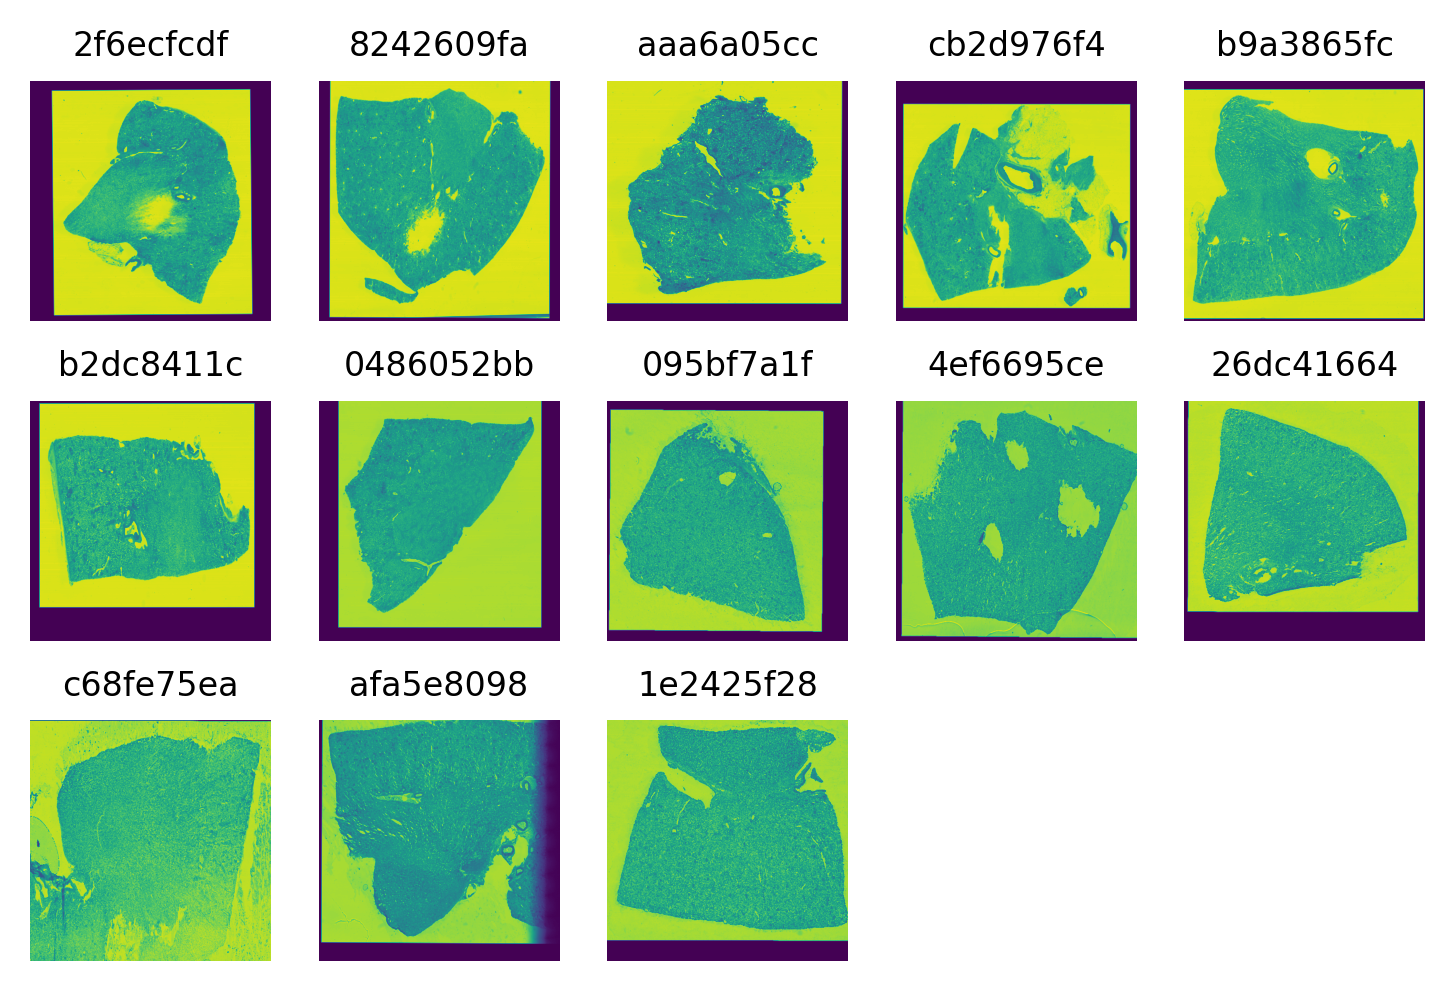

In [23]:
plt.figure(dpi=300)
for i, (sample_id, image) in enumerate(im_dict.items()):
    

    plt.subplot(3,5,i+1)
    
    plt.title(sample_id, fontdict={'fontsize':8})
    plt.imshow(image)
    plt.axis('off')
plt.save()
plt.show()

Apparently there is some problem with samples e79de561c and 54f2eec69 and they can't be loaded using the same procedure as the rest of them. Also, samples 4ef6695ce, 26dc41664, c68fe75ea, and 1e2425f28 apparently only have one channel unlike the rest of the images that have 3. An option for this could be reduce the number of channels of the other images to be able to process all the images with the same architecture. 

In [23]:
defective_images = ['e79de561c','54f2eec69']

In [24]:
# Remove defective rows
train = train.iloc[~train.sample_id.isin(defective_images).values]

### Image shapes

In [25]:
shape_list = []
for sample_id in train.sample_id:
    # Get the path of the image of the smaple
    path = glob(f"data/train/{sample_id}.tiff")[0]
    
    # Load the image
    with rasterio.open(path) as src:
        shape_list.append(list(src.shape))

/home/adri/anaconda3/envs/hubmap/lib/python3.9/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [26]:
shape_df = pd.DataFrame(shape_list, columns = ['h', 'w'])

<AxesSubplot:xlabel='w', ylabel='h'>

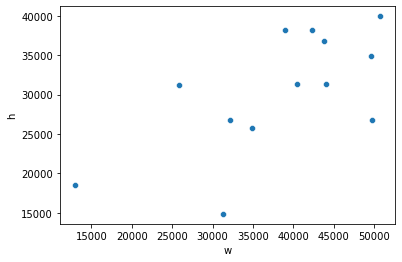

In [27]:
sns.scatterplot(data=shape_df, x='w', y='h')

## Load image metadata

/home/adri/Documents/projects/kaggle/hubmap/utilities.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  polygon = np.array(cd['geometry']['coordinates']).reshape(-1, 2)


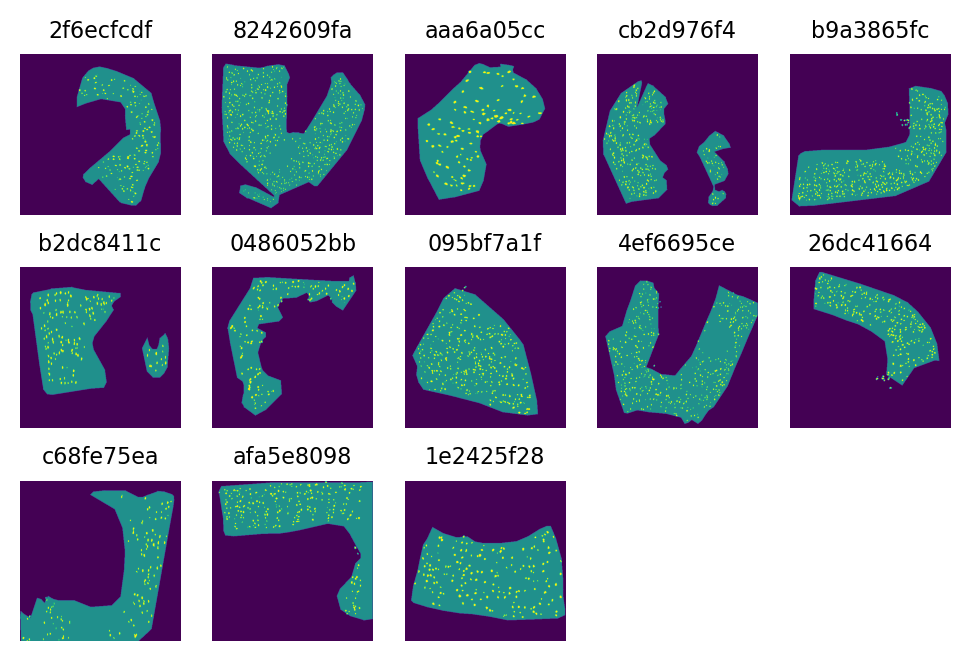

In [28]:
# Plot the cortex mask along with the glomeruli mask
plt.figure(dpi=200)
for i, sample_id in enumerate(train.sample_id):
    cortex_mask = get_mask(sample_id, 'cortex', train, out_shape=(500,500))
    glom_mask = get_mask(sample_id, 'glom', train, out_shape=(500,500))
    
    cortex_mask = cortex_mask.astype(int)
    cortex_mask[glom_mask] = 2
    
    plt.subplot(3,5,i+1)
    plt.title(sample_id, fontdict={'fontsize':8})
    plt.imshow(cortex_mask)
    plt.axis('off')
plt.show()

AS can be seen the majority of the glomerula lay within the cortex of the sample. Because of that, I will train the model on details of the cortex of each sample. In some images, it can be seen that some glomerula fall outside the cortex. For the time being I will ignore those glomerula. 